In [1]:
#Importing Dependencies
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
# INCLUDING 'inspect'
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# Creating an Engine Using SQL Lite File/Data
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [6]:
# Reflect Database into ORM class
# Creating AutoMap
Base = automap_base()
# Reflecting Tables
Base.prepare(engine, reflect=True)

In [7]:
# Viewing Classes in AutoMap
Base.classes.keys()

['measurement', 'station']

In [8]:
# Table References
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Start a session to query the database
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate the date 1 year ago from today
#one_year_ago 

#last_date calculation
last_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [11]:
#one_year_ago from the last data point in the db
one_year_ago = dt.datetime.strptime(str(last_date[0]),'%Y-%m-%d') - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and 
# Sort/ORDER_BY the dataframe by date

prcp = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

#Load the results into a pandas dataframe. Set the index to the `date`
prcp_df = pd.DataFrame(prcp, columns=['date','prcp'])
prcp_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<IPython.core.display.Javascript object>


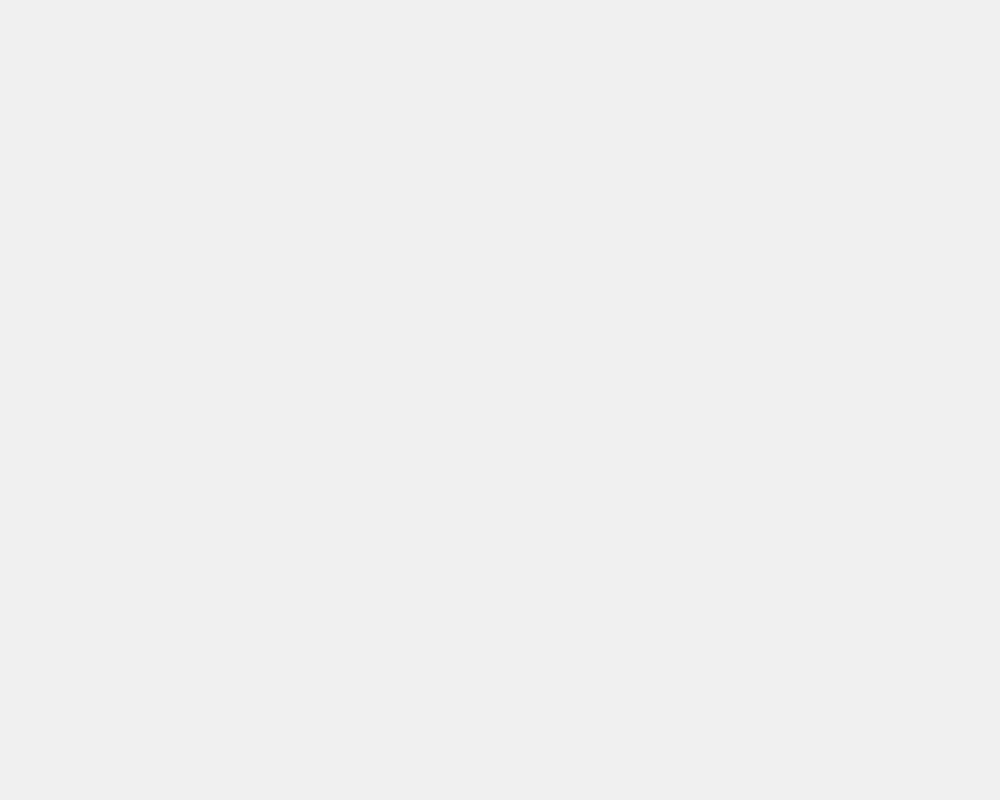

<IPython.core.display.Javascript object>


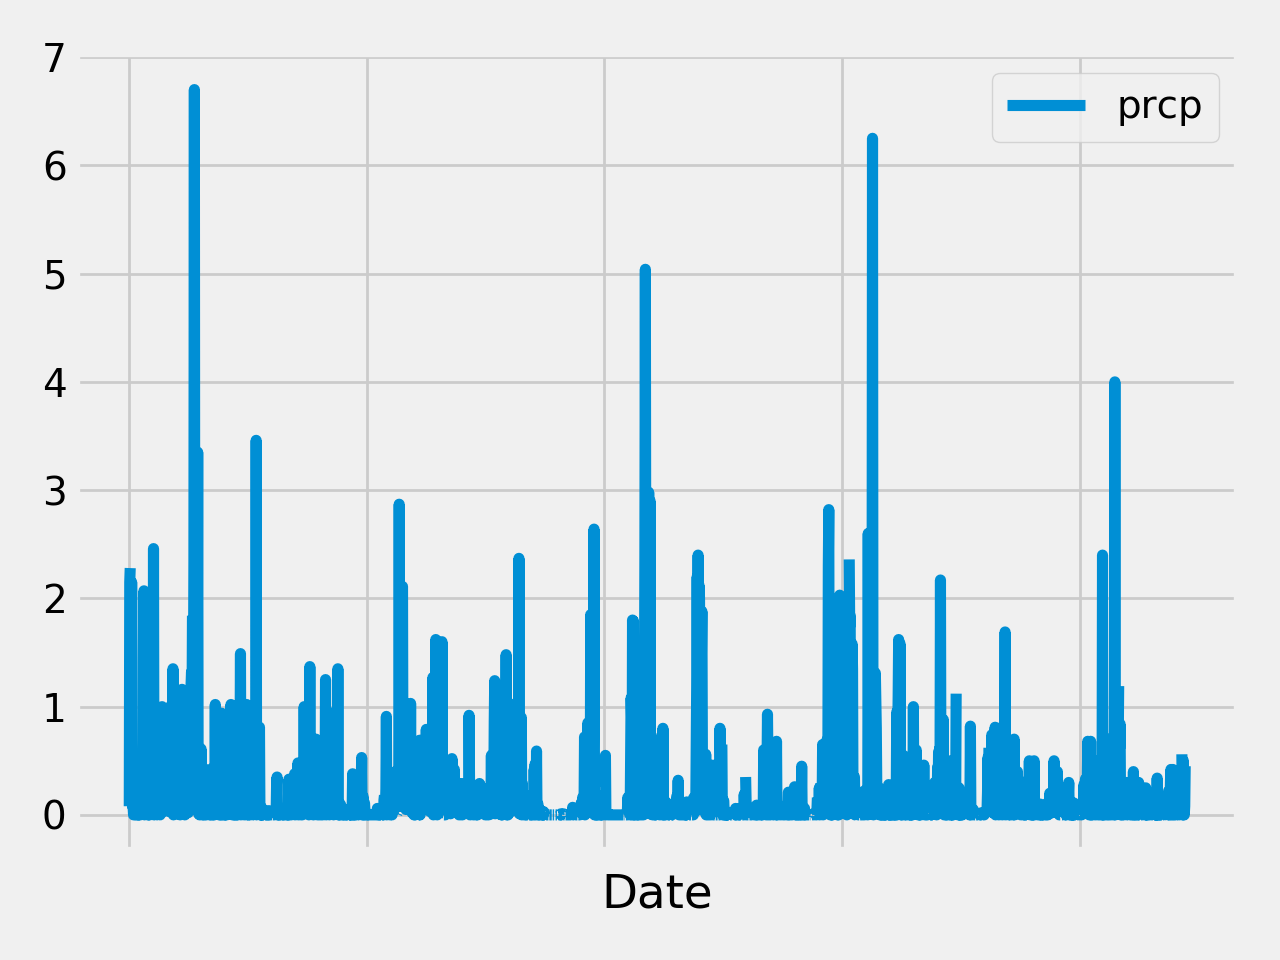

In [76]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure(figsize=(5,4))
prcp_df.plot('date', 'prcp')
plt.grid(True)
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()
#plt.close(fig1)

In [25]:
# Use Pandas to calcualte the summary statistics
# for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# How many stations are available in this dataset?
location_station = session.query(Measurement).group_by(Measurement.station).count()
print(location_station)

9


In [20]:
# What are the most active stations?

weather_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

active_station = weather_observations[0][0]    
active_station

'USC00519281'

In [32]:
# List the stations and the counts in descending order.

for station, count in weather_observations:
      print(station," ",count)

USC00519281   2772
USC00519397   2724
USC00513117   2709
USC00519523   2669
USC00516128   2612
USC00514830   2202
USC00511918   1979
USC00517948   1372
USC00518838   511


In [77]:
# Using the station id from the previous query, 
# calculate the 'lowest temperature' recorded, 
# 'highest temperature' recorded, and 'average temperature' most active station?
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_station).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

<IPython.core.display.Javascript object>


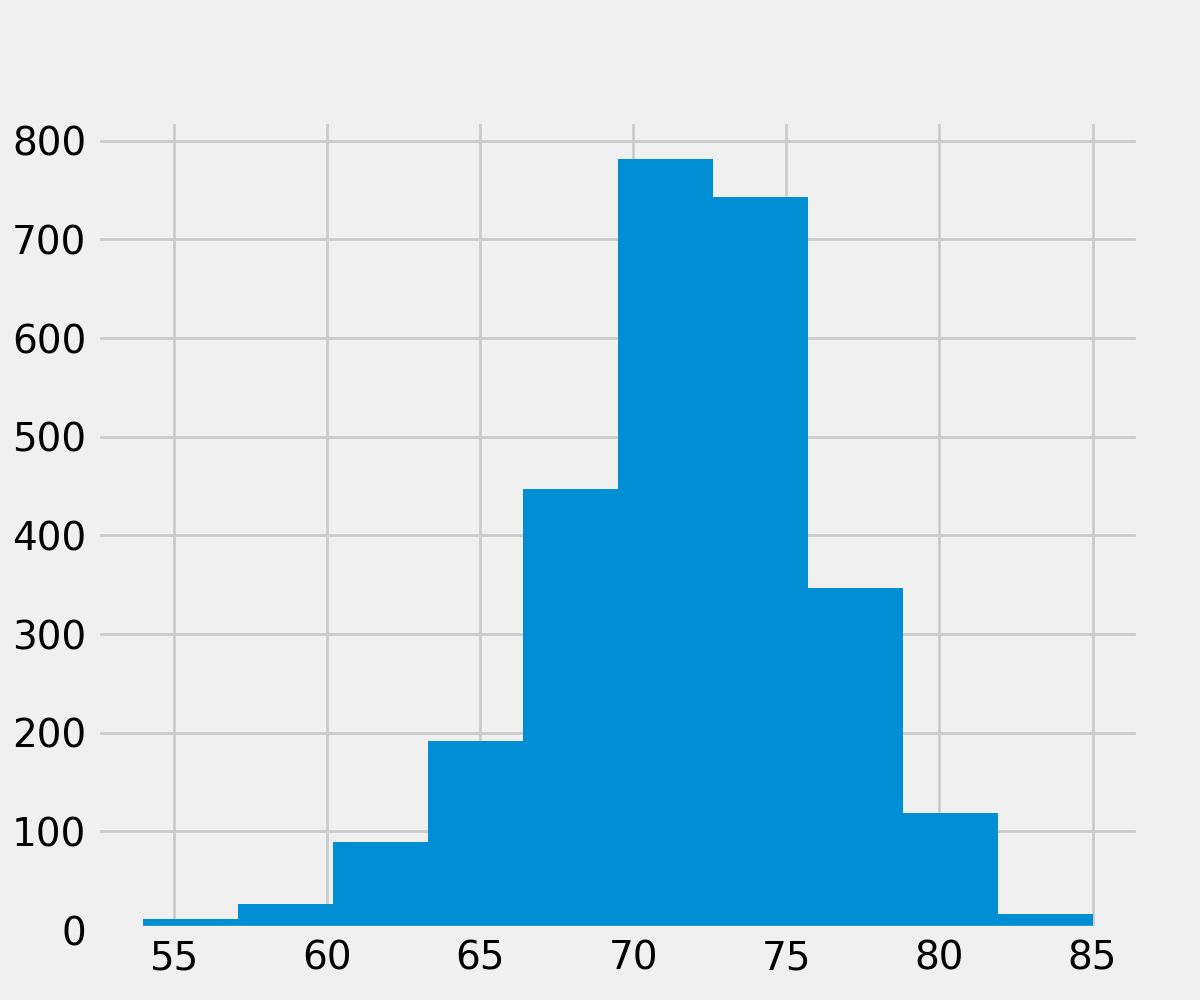

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
fig2 = plt.figure(figsize=(6,5))
plt.grid(True)
temp_df = pd.DataFrame(temperature)
plt.hist(temp_df['tobs'])
bin_size = 12
plt.show()

In [56]:
#  This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [64]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arr_date = dt.date(2012, 2, 28)
d_date = dt.date(2012, 3, 5)
year_ago = dt.timedelta(days=365)
tavg_ago = (calc_temps((arr_date-year_ago), (d_date-year_ago)))
print(tavg_ago)

[(61.0, 70.08928571428571, 75.0)]


<IPython.core.display.Javascript object>


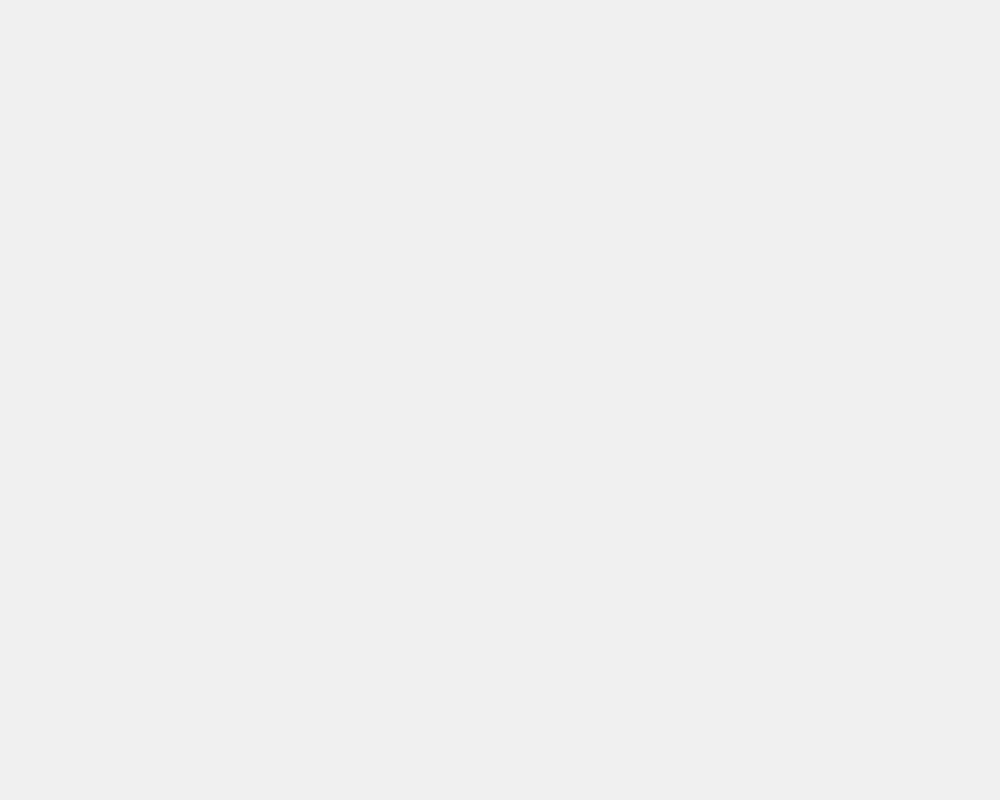

<IPython.core.display.Javascript object>


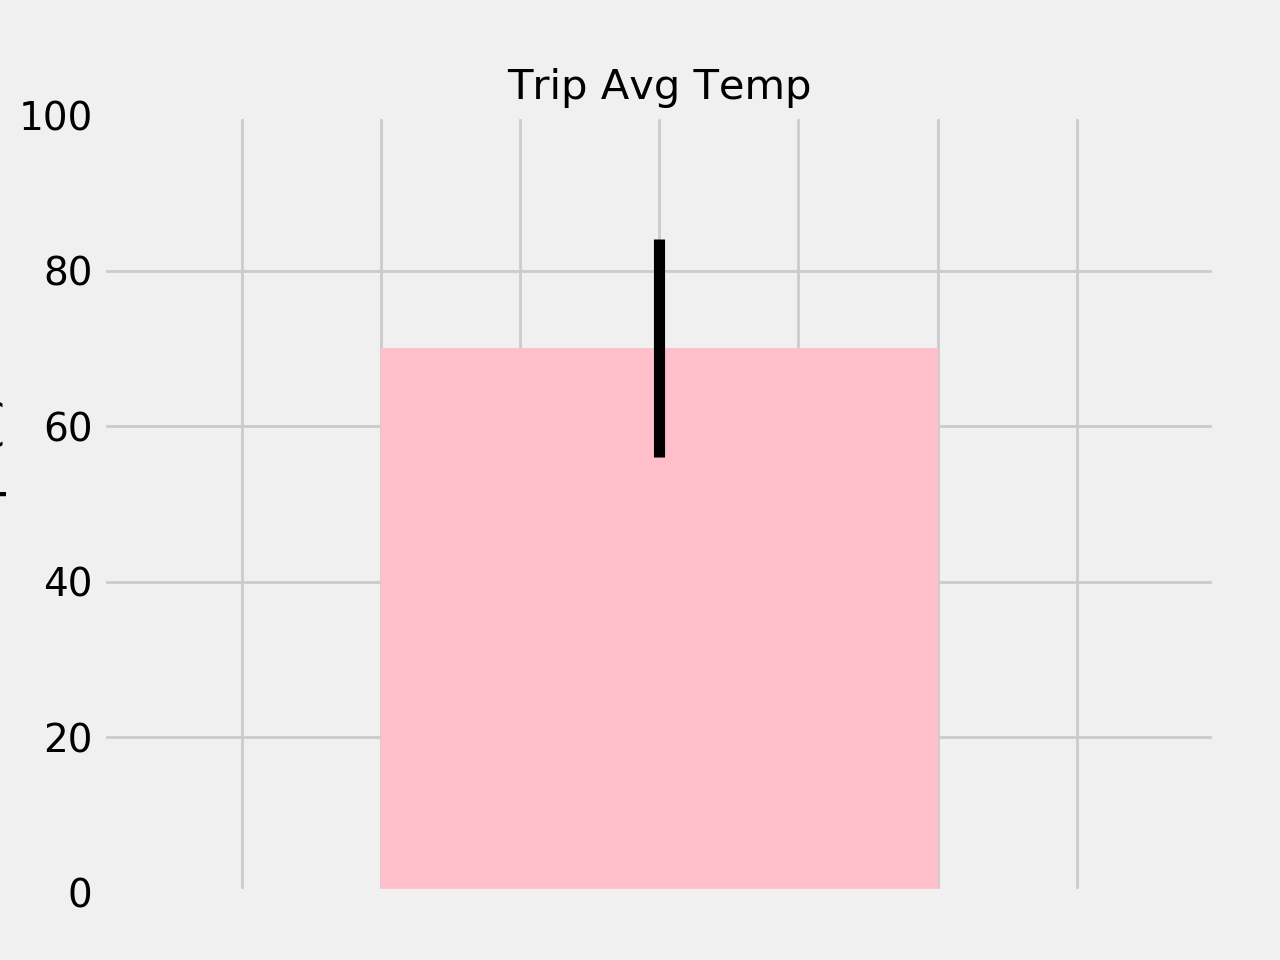

/Users/osama/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [91]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# plt.subplots(figsize=(6,5))
# plt.xlim(0, 2)
# plt.ylim([0,110])
# plt.bar(1, TAVG, color = 'orange', yerr = TMAX-TMIN, tick_label="", align='center')
# plt.title(f"Trip Ave Temp\n Historical Data from:  {search_sd} - {search_ed}", fontsize=14)
# plt.ylabel("Temp (F)")
# plt.tight_layout()

yl = tavg_ago[0][2] - tavg_ago[0][0]

# Y value is the average temperature for the trip's date range; X is zero since we only need one bar
y = [tavg_ago[0][1]]
x = 0

fig3 = plt.figure(figsize=(5,4))
fig, ax = plt.subplots()

ax.set_ylabel(" Temp (F)")
ax.set_title("Trip Avg Temp", fontsize=15)

ax.bar(x, y, width=1, color="pink", yerr=yl)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x',labelbottom='off', which='both', bottom='off', top='off' ) 
plt.show()

In [107]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

x = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= arr_date)\
.filter(Measurement.date <= d_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())
for row in x:
      rain="{0:.2f}".format(row[1])
      print ( row[0],rain,row[2],row[3],row[4],row[5])
      print()


USC00519281 11.08 WAIHEE 837.5, HI US 32.9 21.45167 -157.84888999999998

USC00516128 10.32 MANOA LYON ARBO 785.2, HI US 152.4 21.3331 -157.8025

USC00513117 5.79 KANEOHE 838.1, HI US 14.6 21.4234 -157.8015

USC00518838 3.84 UPPER WAHIAWA 874.3, HI US 306.6 21.4992 -158.0111

USC00519523 2.92 WAIMANALO EXPERIMENTAL FARM, HI US 19.5 21.33556 -157.71139

USC00519397 1.18 WAIKIKI 717.2, HI US 3.0 21.2716 -157.8168

USC00511918 0.76 HONOLULU OBSERVATORY 702.2, HI US 0.9 21.3152 -157.9992

USC00514830 0.03 KUALOA RANCH HEADQUARTERS 886.9, HI US 7.0 21.5213 -157.8374

USC00517948 0.00 PEARL CITY, HI US 11.9 21.3934 -157.9751

